In [1]:
# Python ≥3.5 is required
import sys

import keras.datasets.mnist

print("Python: ", sys.version_info)
assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
print("sklearn version: ", sklearn.__version__)
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.8 is required
import tensorflow as tf
print("TF version: ", tf.__version__)
# assert tf.__version__ >= "2.8"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")

# GPU test
print("GPU installed: ",tf.test.is_built_with_gpu_support())

# To prevent "CUDNN_STATUS_ALLOC_FAILED" error with GPUs
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

# Common imports
import numpy as np
import os
import pandas as pd
import tensorflow_datasets as tfds
from tensorflow_datasets.core.utils import gcs_utils
gcs_utils._is_gcs_disabled = True
from tensorflow import keras


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

2024-06-09 21:43:28.459790: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-09 21:43:28.459850: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-09 21:43:28.510749: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-09 21:43:28.611565: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-09 21:43:29.543855: W tensorflow/compiler/tf2

Python:  sys.version_info(major=3, minor=9, micro=19, releaselevel='final', serial=0)
sklearn version:  1.4.1.post1
TF version:  2.15.0


2024-06-09 21:43:30.656746: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:43:30.843388: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:43:30.843434: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:43:30.846609: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-09 21:43:30.846684: I external/local_xla/xla/stream_executor

GPU installed:  True
1 Physical GPUs, 1 Logical GPUs


In [38]:
def getClasses(type):
    file = open("datasets/emnist/emnist-" + nameList[type] + "-mapping.txt", 'r')
    lines = file.readlines()

    classes = []

    for line in lines:
        classes.append(chr(int(line.split()[-1])))

    file.close()

    return classes


classes_bal = getClasses(0)
classes_class = getClasses(1)
classes_merge = getClasses(2)

NameError: name 'nameList' is not defined

최종적으로 더 나은 결과값을 보여준 resnet50가 선정되었고, 해당 model에 진행된 최적의 parameter를 적용하여 global minimum에 도달할 수 있도록 함.

적용 내용:
- resnet50
- activation function: relu / prelu / elu - renet 쪽에서 가장 좋은 결과를 보여준 함수들 
- kernel initializer는 크게 영향을 주지 않아 설정하지 않음
- callback은 global minimum에 근접할 수 있도록 patience 값을 크게 잡음
- 마지막 dense layer에 dropout(0.5) 적용
- epoch: 100

In [6]:
# dataset

import tensorflow_datasets as tfds

(train_data, valid_data, test_data), info = tfds.load("emnist/byclass", split=["train[:80%]", "train[80%:]", "test"], as_supervised=True, with_info=True)

In [7]:
from tensorflow.keras import layers

def preprocess_resnet50(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Convert grayscale to RGB by duplicating the single channel
    image = tf.image.grayscale_to_rgb(image)
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label

# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

# 사용하지 않음
def preprocess_resnet50_with_aug(image, label):
    # Resize image to (32, 32, 1)
    image = tf.image.resize(image, size=(32, 32))
    # Convert grayscale to RGB by duplicating the single channel
    image = tf.image.grayscale_to_rgb(image)
    # Apply data augmentation
    image = data_augmentation(image)
    # Rescale pixel values to [0, 1]
    image = tf.cast(image, tf.float64) / 255.0
    return image, label

In [8]:
# prepare - rescale

train_data = train_data.map(preprocess_resnet50)
valid_data = valid_data.map(preprocess_resnet50)
test_data = test_data.map(preprocess_resnet50)

batch_size = 32
train_data = train_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
valid_data = valid_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
test_data = test_data.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import PReLU, LeakyReLU, ELU

def res_block(x, filters, kernel_size=3, stride=1, activation='relu'):
    y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    y = BatchNormalization()(y)
    y = _get_activation_layer(activation)(y)
    
    y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
    y = BatchNormalization()(y)
    
    if stride != 1 or x.shape[-1] != filters:
        x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
    
    out = Add()([x, y])
    out = _get_activation_layer(activation)(out)
    return out

def _get_activation_layer(activation):
    if activation == 'relu':
        return Activation('relu')
    elif activation == 'prelu':
        return PReLU()
    elif activation == 'elu':
        return ELU()
    else:
        raise ValueError("Unsupported activation function: {}".format(activation))

def build_light_resnet50(input_shape, num_classes, activation='relu'):
    inputs = Input(shape=input_shape)
    x = Conv2D(16, (3, 3), padding='same', strides=1)(inputs)
    x = BatchNormalization()(x)
    x = _get_activation_layer(activation)(x)
    
    x = res_block(x, 16, stride=1, activation=activation)
    x = res_block(x, 16, stride=1, activation=activation)
    
    x = res_block(x, 32, stride=2, activation=activation)
    x = res_block(x, 32, stride=1, activation=activation)
    
    x = res_block(x, 64, stride=2, activation=activation)
    x = res_block(x, 64, stride=1, activation=activation)
    
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    return model

In [9]:
# model prepare



# from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, Input, Dense, GlobalAveragePooling2D, Dropout, PReLU, ELU
# from tensorflow.keras.models import Model
# 
# 
# 
# def res_block(x, filters, kernel_size=3, stride=1, activation='relu'):
#     y = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
#     y = BatchNormalization()(y)
#     if activation == 'relu':
#         y = Activation('relu')(y)
#     elif activation == 'prelu':
#         y = PReLU()(y)
#     elif activation == 'elu':
#         y = elu()(y)
#     
#     y = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(y)
#     y = BatchNormalization()(y)
#     
#     if stride != 1 or x.shape[-1] != filters:
#         x = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(x)
#     
#     out = Add()([x, y])
#     out = Activation('relu')(out)
#     return out
# 
# def build_light_resnet50(input_shape, num_classes, activation='relu'):
#     inputs = Input(shape=input_shape)
#     x = Conv2D(16, (3, 3), padding='same', strides=1)(inputs)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     
#     x = res_block(x, 16, stride=1, activation=activation)
#     x = res_block(x, 16, stride=1, activation=activation)
#     
#     x = res_block(x, 32, stride=2, activation=activation)
#     x = res_block(x, 32, stride=1, activation=activation)
#     
#     x = res_block(x, 64, stride=2, activation=activation)
#     x = res_block(x, 64, stride=1, activation=activation)
#     
#     x = GlobalAveragePooling2D()(x)
#     x = Dropout(0.5)(x)
#     outputs = Dense(num_classes, activation='softmax')(x)
#     
#     model = Model(inputs, outputs)
#     return model

In [10]:
input_shape = (32, 32, 3)
num_classes = 62
final_model = build_light_resnet50(input_shape, num_classes)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 16)           448       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 16)           64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 16)           0         ['batch_normalization[0][0

In [22]:
# callbacks & optimizer

learning_rate = 0.001

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5, patience=5, min_lr=0.00001)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

In [12]:
# training

# relu
batch_size = 16

final_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = final_model.fit(train_data, epochs=100, validation_data=valid_data, callbacks=callbacks, batch_size=batch_size)

Epoch 1/100


2024-06-09 21:44:05.411973: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-06-09 21:44:07.141123: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f4e2dcdf790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-09 21:44:07.141149: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2024-06-09 21:44:07.150545: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1717937047.218961     713 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


17449/17449 [==============================] - 222s 12ms/step - loss: 0.8241 - accuracy: 0.7644 - val_loss: 0.4294 - val_accuracy: 0.8458 - lr: 0.0010
Epoch 2/100
17449/17449 [==============================] - 211s 12ms/step - loss: 0.4985 - accuracy: 0.8352 - val_loss: 0.4141 - val_accuracy: 0.8508 - lr: 0.0010
Epoch 3/100
17449/17449 [==============================] - 208s 12ms/step - loss: 0.4583 - accuracy: 0.8456 - val_loss: 0.3895 - val_accuracy: 0.8571 - lr: 0.0010
Epoch 4/100
17449/17449 [==============================] - 212s 12ms/step - loss: 0.4354 - accuracy: 0.8517 - val_loss: 0.3796 - val_accuracy: 0.8614 - lr: 0.0010
Epoch 5/100
17449/17449 [==============================] - 211s 12ms/step - loss: 0.4216 - accuracy: 0.8551 - val_loss: 0.3779 - val_accuracy: 0.8611 - lr: 0.0010
Epoch 6/100
17449/17449 [==============================] - 212s 12ms/step - loss: 0.4114 - accuracy: 0.8576 - val_loss: 0.3755 - val_accuracy: 0.8634 - lr: 0.0010
Epoch 7/100
17449/17449 [=========

In [19]:
tf.keras.backend.clear_session()

learning_rate = 0.001

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5, patience=5, min_lr=0.00001)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

# prelu

final_model_2 = build_light_resnet50(input_shape, num_classes, activation='prelu')

final_model_2.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_2 = final_model_2.fit(train_data, epochs=100, validation_data=valid_data, callbacks=callbacks, batch_size=batch_size)

Epoch 1/100
17449/17449 [==============================] - 342s 19ms/step - loss: 0.7107 - accuracy: 0.7907 - val_loss: 0.4130 - val_accuracy: 0.8524 - lr: 0.0010
Epoch 2/100
17449/17449 [==============================] - 343s 20ms/step - loss: 0.4375 - accuracy: 0.8494 - val_loss: 0.3891 - val_accuracy: 0.8601 - lr: 0.0010
Epoch 3/100
17449/17449 [==============================] - 350s 20ms/step - loss: 0.4052 - accuracy: 0.8575 - val_loss: 0.3768 - val_accuracy: 0.8649 - lr: 0.0010
Epoch 4/100
17449/17449 [==============================] - 353s 20ms/step - loss: 0.3878 - accuracy: 0.8620 - val_loss: 0.3633 - val_accuracy: 0.8669 - lr: 0.0010
Epoch 5/100
17449/17449 [==============================] - 357s 20ms/step - loss: 0.3750 - accuracy: 0.8652 - val_loss: 0.3569 - val_accuracy: 0.8708 - lr: 0.0010
Epoch 6/100
  846/17449 [>.............................] - ETA: 5:12 - loss: 0.3740 - accuracy: 0.8679

KeyboardInterrupt: 

속도가 350s으로 많이 느려서 도중에 탈락시킴

In [23]:
tf.keras.backend.clear_session()

learning_rate = 0.001

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=10,
                                                     restore_best_weights=True,verbose=1)
rlr = tf.keras.callbacks.ReduceLROnPlateau(verbose=1, mode="auto", factor=0.5, patience=5, min_lr=0.00001)
callbacks = [early_stopping_cb, rlr]
optimizer = tf.keras.optimizers.Adamax(learning_rate=learning_rate)

# elu

final_model_3 = build_light_resnet50(input_shape, num_classes, activation='elu')

final_model_3.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_3 = final_model_3.fit(train_data, epochs=100, validation_data=valid_data, callbacks=callbacks, batch_size=batch_size)

Epoch 1/100
17449/17449 [==============================] - 217s 12ms/step - loss: 0.7692 - accuracy: 0.7743 - val_loss: 0.4356 - val_accuracy: 0.8466 - lr: 0.0010
Epoch 2/100
17449/17449 [==============================] - 213s 12ms/step - loss: 0.4761 - accuracy: 0.8392 - val_loss: 0.3992 - val_accuracy: 0.8519 - lr: 0.0010
Epoch 3/100
17449/17449 [==============================] - 216s 12ms/step - loss: 0.4389 - accuracy: 0.8487 - val_loss: 0.3769 - val_accuracy: 0.8635 - lr: 0.0010
Epoch 4/100
17449/17449 [==============================] - 220s 13ms/step - loss: 0.4194 - accuracy: 0.8535 - val_loss: 0.3729 - val_accuracy: 0.8625 - lr: 0.0010
Epoch 5/100
17449/17449 [==============================] - 217s 12ms/step - loss: 0.4065 - accuracy: 0.8572 - val_loss: 0.3647 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 6/100
17449/17449 [==============================] - 217s 12ms/step - loss: 0.3974 - accuracy: 0.8594 - val_loss: 0.3616 - val_accuracy: 0.8672 - lr: 0.0010
Epoch 7/100
17449/1744

In [31]:
final_model.evaluate(valid_data)

4363/4363 [==============================] - 22s 5ms/step - loss: 0.3531 - accuracy: 0.8769


[0.35309937596321106, 0.8768787980079651]

In [32]:
final_model_3.evaluate(valid_data)

4363/4363 [==============================] - 25s 6ms/step - loss: 0.3331 - accuracy: 0.8791


[0.333129346370697, 0.8791067600250244]

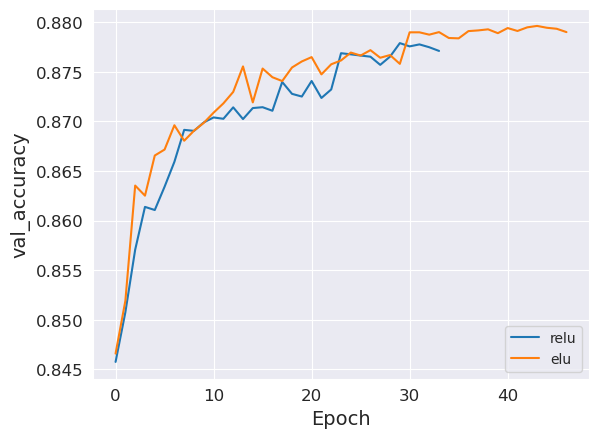

In [34]:
# compare

import matplotlib.pyplot as plt

plt.plot(history.history['val_accuracy'], label='relu')
plt.plot(history_3.history['val_accuracy'], label = 'elu')
plt.xlabel('Epoch')
plt.ylabel('val_accuracy')
plt.legend(loc='lower right')
plt.show()

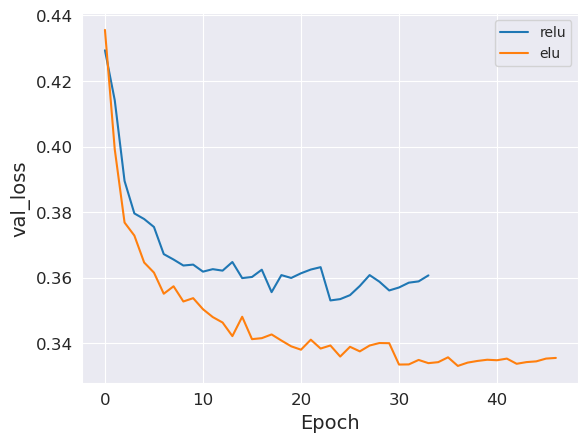

In [35]:
plt.plot(history.history['val_loss'], label='relu')
plt.plot(history_3.history['val_loss'], label = 'elu')
plt.xlabel('Epoch')
plt.ylabel('val_loss')
plt.legend(loc='upper right')
plt.show()

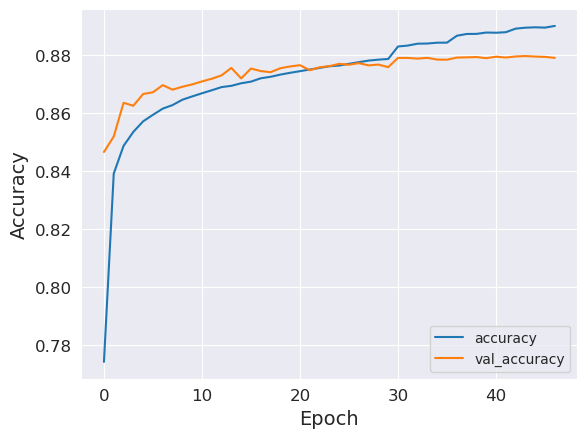

In [26]:
# check overfit

plt.plot(history_3.history['accuracy'], label='accuracy')
plt.plot(history_3.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

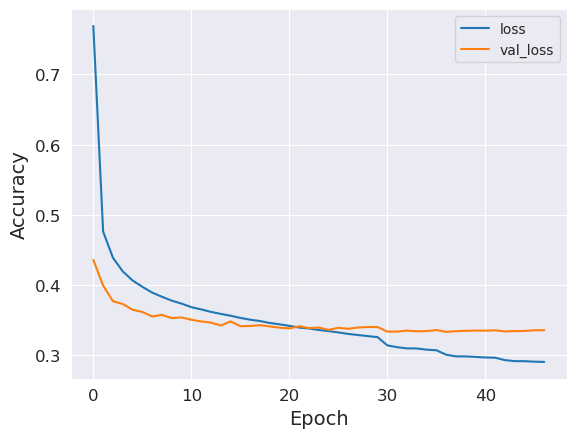

In [27]:
plt.plot(history_3.history['loss'], label='loss')
plt.plot(history_3.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper right')
plt.show()

In [36]:
# model test data evaluate

model_loss, model_acc = final_model_3.evaluate(test_data)
print(f"Test Loss: {np.round(model_loss,3)}, Test Accuracy: {np.round(model_acc,3)}")

3636/3636 [==============================] - 21s 6ms/step - loss: 0.3341 - accuracy: 0.8783
Test Loss: 0.334, Test Accuracy: 0.878


In [37]:
# model save

from pathlib import Path

MODEL_PATH = Path() / "models" / "final"
MODEL_PATH.mkdir(parents=True, exist_ok=True)

final_model.save(MODEL_PATH / "final_model.keras")